# DD2437
## Lab 1B - Part II

**Group 26**

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt


2026-02-09 11:14:26.689299: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-09 11:14:26.831608: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-09 11:14:29.693147: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
'''
Seting parameters as according to instructions.
'''
beta = 0.2
gamma = 0.1
n = 10
tau = 25 # tau > 17

In [4]:
'''
We define the Mackey-Glass function as according
to the given formula and make use of the global
parameters defined.

Note that x_t_tau is the value of x at time t - tau.
'''
def mackey_glass_step(x_t):
    x_t_tau = x_t - tau
    return x_t + beta * x_t_tau / (1 + x_t_tau**n) - gamma * x_t

In [5]:
'''
Prepare a embedded time-lagged representation by picking
1200 points from t301 to 1500, which we will use for training,
validation, and testing.
'''
t = np.arange(301, 1501)

def get_input(t):
    X = []
    for i in range(20, -1, -5):
        X.append(mackey_glass_step(t - i))
    return np.array(X)

def get_output(t):
    return mackey_glass_step(t + 5)

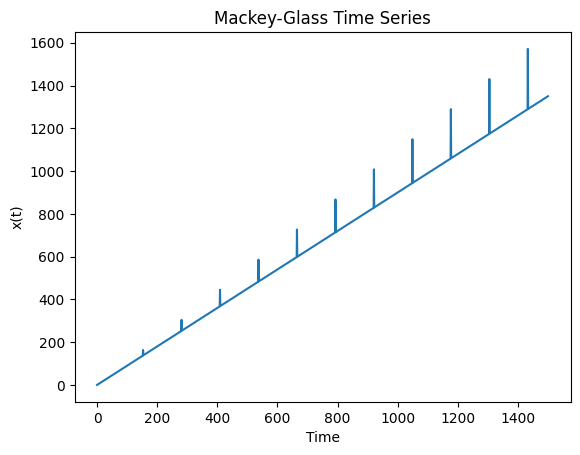

In [ ]:
'''
We plot the time series for a better understainding of the data.
'''
time_series = [mackey_glass_step(ti) for ti in range(1, 1501)]
plt.plot(time_series)
plt.title('Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.show()

(5, 1200)
(1200,)
[[304.1 253.8 254.7 255.6 256.5]
 [257.4 258.3 259.2 260.1 261. ]
 [261.9 262.8 263.7 264.6 265.5]
 [266.4 267.3 268.2 269.1 270. ]
 [270.9 271.8 272.7 273.6 274.5]]
[275.4 276.3 277.2 278.1 279. ]


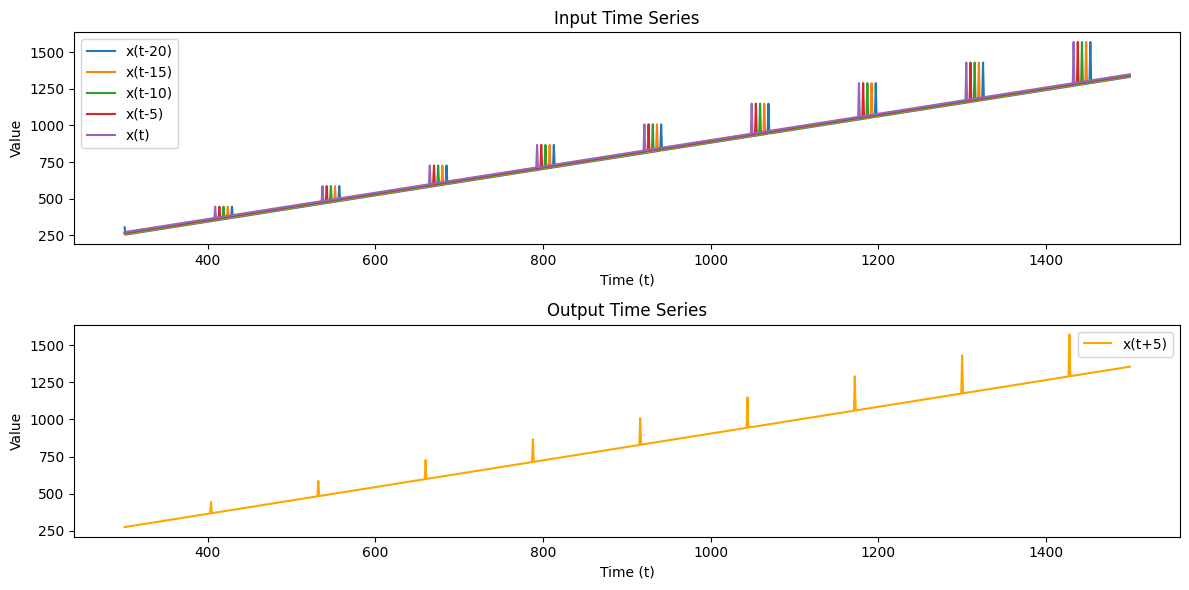

In [ ]:
'''
Explore the data in order to get a better understanding and
double check that it is correct.
'''
X = get_input(t)
Y = get_output(t)
print(X.shape)
print(Y.shape)
print(X[:, :5])
print(Y[:5])

Shapes does seem to check out, though ght other values are yet unclear.

In [ ]:
'''
We split up the dataset into training, validation, and testing sets
but wihtout shuffling in order to keep the ordering of the data.
'''
X_train = X[:, :800]
Y_train = Y[:800]

X_val = X[:, 800:1000]
Y_val = Y[800:1000]

X_test = X[:, 1000:]
Y_test = Y[1000:]

#print(X_train.shape, Y_train.shape)
#print(X_val.shape, Y_val.shape)
#print(X_test.shape, Y_test.shape)

In [8]:
'''
Then we setup the training process with batch learning and
early stopping in order to prevent overfitting and base it on
the validation loss.
'''
def train_model(model, X_train, Y_train, X_val, Y_val):
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    history = model.fit(
        X_train.T,
        Y_train,
        validation_data=(X_val.T, Y_val),
        epochs=256,
        batch_size=16,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
        ],
        verbose=2
    )
    return history

In [9]:
'''
Helper function to plot the training and validation loss over epochs.
'''
def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [10]:
'''
Wrapper function for training, plotting history, and
evaluating the model on the test set.
'''
def train_and_evaluate(model, X_train, Y_train, X_val, Y_val, X_test, Y_test):
    history = train_model(model, X_train, Y_train, X_val, Y_val)
    plot_history(history)
    test_loss = model.evaluate(X_test.T, Y_test, verbose=0)
    print(f'Test Loss: {test_loss:.4f}')


In [11]:
'''
Now we setup the network structure as instruced:
5 input neurons and 1 output neuron.

Note that were using sigmoid activation for the hidden layer and
linear activation for the output layer as instructed.
'''
model = Sequential([
    Dense(
        5,
        activation='sigmoid',
        kernel_regularizer=l2(1e-4),
        input_shape=(5,)
    ),
    Dense(1, activation='linear')
])

/home/william/Repositories/DD2437/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-02-09 11:14:31.876608: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Using batch size = 16, and ADAM for adjusting learning rate. The tests were run 5 times each.

No L2: val_loss=578

L2 (1e*4): val_loss=583

L1 (1e*4): val_loss=708

Meaning in this limited amount of tests, we found that no weight regularization or L2 (ridge) perfomre better than L1. This is likely due to L2 enforcing smooth small weights (and not sparsity), which is helpful in this case as there are so few weights in total due to the small network size. In addition, all the data feed to the network [x(t−20),x(t−15),x(t−10),x(t−5),x(t)] are important, thus sparsity would ruin the calculations.